In [1]:
import pandas as pd
import numpy as np
from DataLoader import DataLoader, SyntheticDataLoader
from river import metrics
from river import drift
from river import base
from collections import deque, Counter
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 500

class BollingerBandDriftDetector:
    def __init__(self, window_size=20, num_std=3.5, next_drift_delay=100):
        self.window_size = window_size
        self.num_std = num_std
        self.values = deque(maxlen=window_size)
        self.drift_detected = False
        self.next_drift_delay = next_drift_delay
        self.current_next_drift_delay = 0

    def update(self, value: float):
        self.values.append(value)
        self.drift_detected = False  # Reset flag
        self.current_next_drift_delay = max(0, self.current_next_drift_delay - 1)
        
        if len(self.values) < self.window_size:
            return  # Not enough data yet
        
        mean = np.mean(self.values)
        std = np.std(self.values)
        upper_band = mean + self.num_std * std
        lower_band = mean - self.num_std * std

        # If current value is outside bands -> drift
        if (value > upper_band or value < lower_band) and self.current_next_drift_delay == 0:
            self.drift_detected = True
            self.current_next_drift_delay = self.next_drift_delay # min of instances between next drifts
  

In [2]:
class NoChangeClassifier(base.Classifier):
    def __init__(self):
        self.last_label = None

    def learn_one(self, x, y):
        self.last_label = y
        return self

    def predict_one(self, x):
        return self.last_label

class MajorityClassClassifier(base.Classifier):
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.window = deque()
        self.class_counts = Counter()
        self.majority_class = None

    def learn_one(self, x, y):
        self.window.append(y)
        self.class_counts[y] += 1

        if len(self.window) > self.window_size:
            old_y = self.window.popleft()
            self.class_counts[old_y] -= 1
            if self.class_counts[old_y] == 0:
                del self.class_counts[old_y]

        if self.class_counts:
            self.majority_class = self.class_counts.most_common(1)[0][0]

        return self

    def predict_one(self, x):
        return self.majority_class

class StockPredictor_Naive:

    def __init__(self, stock_data, model_name, drift_name, provided_model=None, provided_detector=None, learning_threshold = 1000):
        self.stock_data = stock_data
        self.data_stream = StockPredictor_Naive.ohlc_stream(stock_data)
        self.metric = metrics.ClassificationReport()
        self.learning_threshold = learning_threshold
        self.drifts_detected = 0

        self.model_name = model_name
        self.provided_model = provided_model

        if provided_model:
            self.model = provided_model
        else:
            self.model= StockPredictor_Naive.get_model(model_name)

        self.drift_name = drift_name
        self.drift_detector = provided_detector or StockPredictor_Naive.get_drift_detector(drift_name)
        self.drift_days = []

    @staticmethod
    def ohlc_stream(df):
        for _, row in df.iterrows():
            features = row.iloc[:-1].to_dict()
            yield features, row['target']

    @staticmethod
    def get_model(name: str):
        name = name.lower()
        if name == 'nochange':
            return NoChangeClassifier()
        if name == 'majorityclass':
            return MajorityClassClassifier()
        else:
            raise ValueError(f"Unknown model")

    @staticmethod
    def get_drift_detector(name: str):
        name = name.lower()
        if name == "adwin":
            return drift.ADWIN()
        elif name == "kswin":
            return drift.KSWIN()
        elif name == "dummydriftdetector":
            return drift.DummyDriftDetector()
        elif name == "pagehinkley":
            return drift.PageHinkley()
        elif name == 'bollingerband':
            return BollingerBandDriftDetector()
        else:
            raise ValueError(f"Unknown detector")

    def prediction(self):
        for i, (x, y) in enumerate(self.data_stream):
            close_value = float(self.stock_data.loc[i, 'close'])

            if i >= self.learning_threshold:
                y_pred = self.model.predict_one(x)
                
                self.model.learn_one(x, y)

                error = int(y_pred != y) if y_pred is not None else 0
                if self.drift_name == 'bollingerband':
                    self.drift_detector.update(close_value)
                else:
                    self.drift_detector.update(error)

                if y_pred is not None:
                    self.metric.update(y, y_pred)

                if self.drift_detector.drift_detected:
                    self.drifts_detected += 1
                    # print(f'Drift detected at index {i}! ({self.drift_name})')
                    self.drift_days.append(i)

                    # resets model
                    if self.provided_model:
                        self.model = self.provided_model
                    else:
                        self.model, _ = StockPredictor_Naive.get_model(self.model_name)        

        accuracy, metrics_result = self.get_metrics()
        # print(f'accuracy: {accuracy}')
        # display(metrics_result)
        return accuracy, metrics_result

    def get_metrics(self):

        classes = sorted(self.metric.cm.classes)

        for c in classes:
            if c not in self.metric._f1s:
                self.metric._f1s[c] = metrics.F1(cm=self.metric.cm, pos_val=c)
        
        accuracy = round(self.metric._accuracy.get(), 3)

        # print(self.metric._f1s)
        metrics_result = pd.DataFrame([ [0, self.metric._f1s[0].precision.get(), self.metric._f1s[0].recall.get(), self.metric._f1s[0].get()],
                                        [1, self.metric._f1s[1].precision.get(), self.metric._f1s[1].recall.get(), self.metric._f1s[1].get()]],
                                        columns=['class', 'precision', 'recall', 'f1'])
        
        metrics_result = metrics_result.round(3)

        return accuracy, metrics_result
    

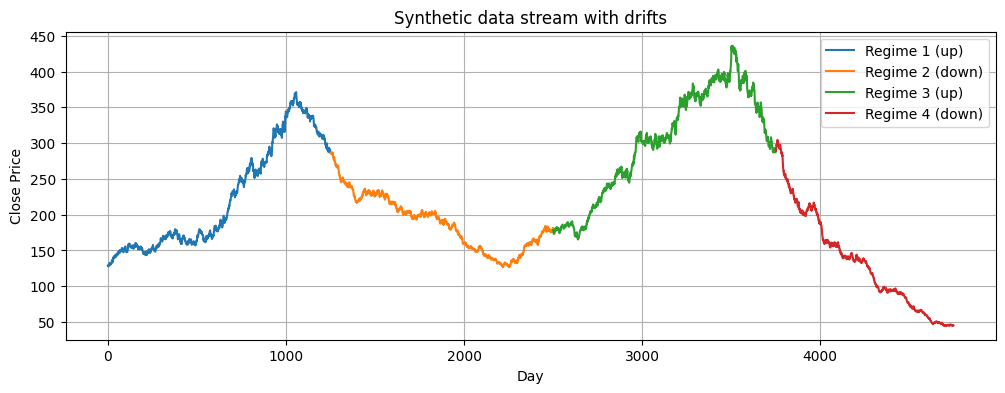

In [18]:
dataLoader = SyntheticDataLoader() 
stock_data, regimes = dataLoader.pipeline(n_days=5000, n_drifts=3, seed=2)

plt.figure(figsize=(12, 4))
for regime in np.unique(regimes):
    subset = [i for i, x in enumerate(regimes) if x == regime]
    plt.plot(subset, stock_data.loc[subset, 'close'], label=f"Regime {regime}")
plt.title("Synthetic data stream with drifts")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

accuracy: 0.533, drifts detected: 2


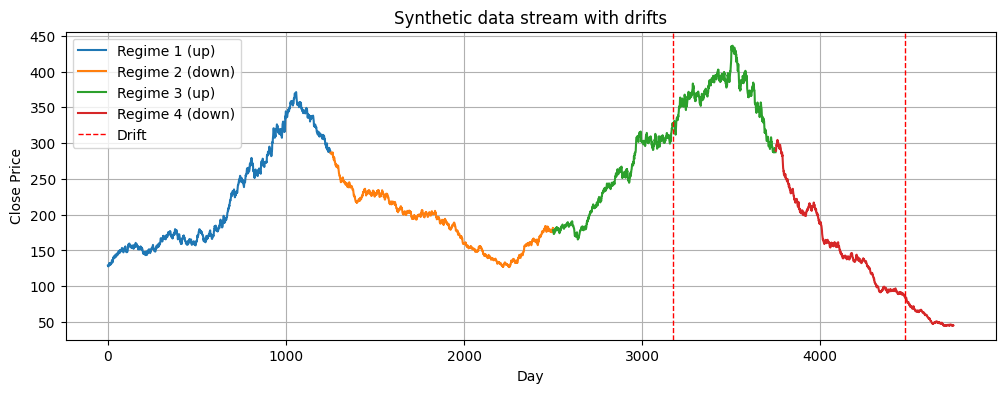

In [15]:
# example 
model_name = 'majorityclass'
args = 100
model = MajorityClassClassifier(args)
# drift_name = 'bollingerband'
# detector = BollingerBandDriftDetector(window_size=100, num_std=3.3, next_drift_delay=100)
drift_name = 'adwin'
detector = drift.KSWIN(alpha = 0.01, window_size = 50, stat_size = 10)
# drift_name = 'pagehinkley'
# detector = drift.PageHinkley(min_instances=30, delta=0.005, threshold = 50, alpha=0.999, mode = 'both')


learning_threshold = 100


stock_predictor = StockPredictor_Naive(stock_data=stock_data,
                                                        model_name=model_name,
                                                        drift_name=drift_name,
                                                        learning_threshold = learning_threshold,
                                                        provided_model=model,
                                                        provided_detector=detector
                                                        )

accuracy, metrics_result = stock_predictor.prediction()
drift_days = stock_predictor.drift_days

print('accuracy: {:.3f}, drifts detected: {}'.format(accuracy, stock_predictor.drifts_detected))

plt.figure(figsize=(12, 4))
for regime in np.unique(regimes):
    subset = [i for i, x in enumerate(regimes) if x == regime]
    plt.plot(subset, stock_data.loc[subset, 'close'], label=f"Regime {regime}")
for x in drift_days:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1, label='Drift' if x == drift_days[0] else "")
plt.title("Synthetic data stream with drifts")
plt.xlabel("Day")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
result_rows = []
for model_name in ['nochange', 'majorityclass']:

    if model_name == 'nochange':
        args_list = [None]
    elif model_name == 'majorityclass':
        args_list = [10, 50, 100, 500, 1000, 2000, 5000, 10000]

    for args in args_list:
        
        if model_name == 'nochange':
            model = NoChangeClassifier()
        elif model_name == 'majorityclass':
            model = MajorityClassClassifier(args)

        for drift_name in ['adwin', 'kswin', 'dummydriftdetector', 'pagehinkley', 'bollingerband']:

            for learning_threshold in [100, 200, 500, 1000, 2000]:

#             print('''
# model_name = {model_name}
# drift_name = {drift_name}
# learning_threshold = {learning_threshold}
# '''.format(
#             model_name=model_name + ('' if model_name == 'nochange' else f'majorityclass({args})'),
#             drift_name=None,
#             learning_threshold=learning_threshold
#             ))

                stock_predictor = StockPredictor_Naive(stock_data=stock_data,
                                                        model_name=model_name,
                                                        drift_name=drift_name,
                                                        learning_threshold = learning_threshold,
                                                        provided_model=model
                                                        )
                                
                accuracy, metrics_result = stock_predictor.prediction()
                drift_days = stock_predictor.drift_days

                result_rows.append([model_name, drift_name, learning_threshold, round(accuracy, 3), stock_predictor.drifts_detected, args])
                # print('accuracy = {:.4f}'.format(accuracy))

result_df = pd.DataFrame(result_rows, columns=['model_name', 'drift_name', 'learning_threshold', 'accuracy', 'drifts_detected', 'model_args'])
result_df.to_csv('results_df_nochange_majorityclass_synth_data.csv', index=False)


In [22]:
sqldf('''
select *
from result_df
order by accuracy desc
''')

,model_name,drift_name,learning_threshold,accuracy,drifts_detected,model_args
0,majorityclass,adwin,2000,0.541,0,500.0
1,majorityclass,kswin,2000,0.541,0,500.0
2,majorityclass,dummydriftdetector,2000,0.541,9,500.0
3,majorityclass,pagehinkley,2000,0.541,1,500.0
4,majorityclass,bollingerband,2000,0.541,0,500.0
...,...,...,...,...,...,...
220,majorityclass,adwin,2000,0.489,1,2000.0
221,majorityclass,kswin,2000,0.489,0,2000.0
222,majorityclass,dummydriftdetector,2000,0.489,9,2000.0
223,majorityclass,pagehinkley,2000,0.489,1,2000.0


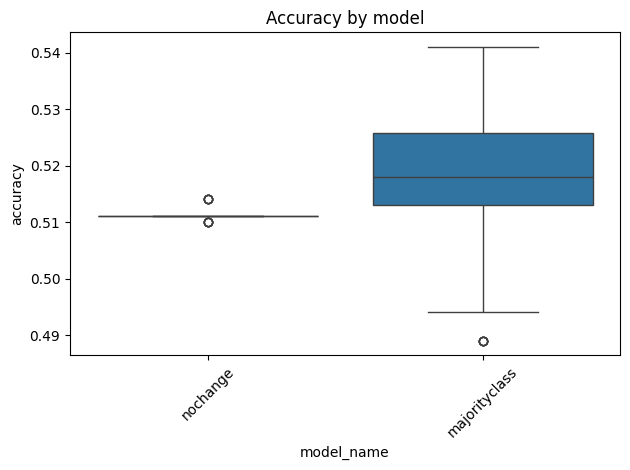

In [23]:
sns.boxplot(x='model_name', y="accuracy", data=result_df)
plt.title("Accuracy by model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

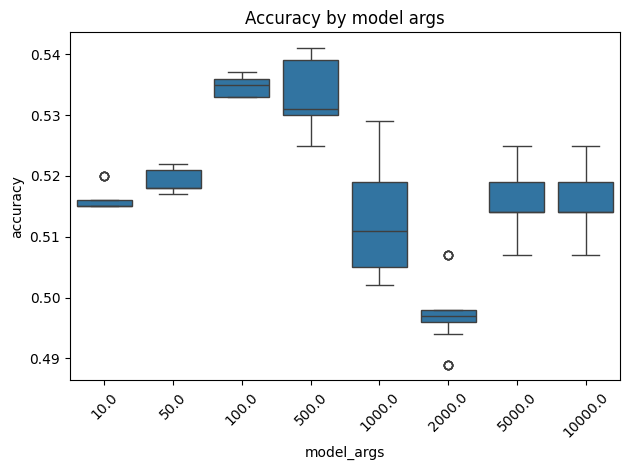

In [24]:
sns.boxplot(x='model_args', y="accuracy", data=result_df)
plt.title("Accuracy by model args")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

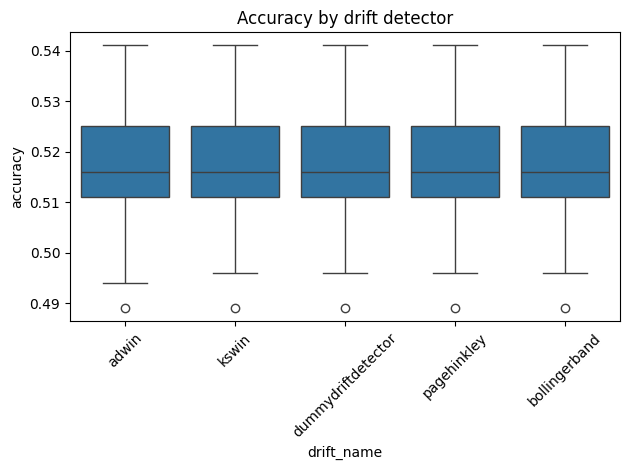

In [25]:
sns.boxplot(x='drift_name', y="accuracy", data=result_df)
plt.title("Accuracy by drift detector")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

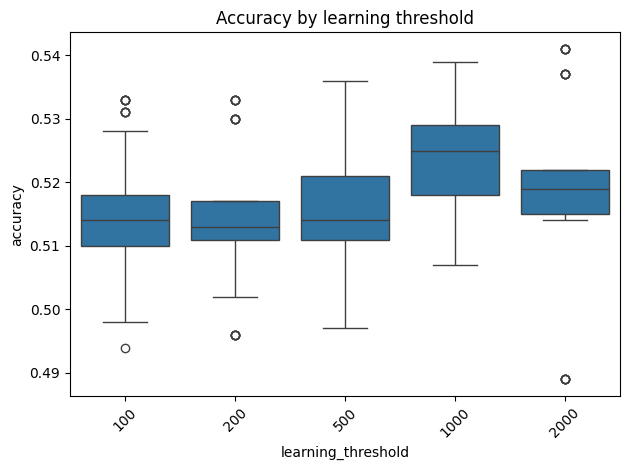

In [26]:
sns.boxplot(x='learning_threshold', y="accuracy", data=result_df)
plt.title("Accuracy by learning threshold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()